

*   List item





In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!cp -r "/content/drive/MyDrive/chest_xray" "/content/"


In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [ ]:
base_path = "/content/chest_xray"
train_dir = os.path.join(base_path, "train")
test_dir  = os.path.join(base_path, "test")


In [ ]:
import os

base_path = "/content/chest_xray"   # change if your dataset path is different

total_images = 0

for folder in ["train", "test", "val"]:
    normal_path = os.path.join(base_path, folder, "NORMAL")
    pneumonia_path = os.path.join(base_path, folder, "PNEUMONIA")

    normal_count = len(os.listdir(normal_path))
    pneumonia_count = len(os.listdir(pneumonia_path))

    folder_total = normal_count + pneumonia_count
    total_images += folder_total

    print(f"{folder.upper()} -> NORMAL: {normal_count}, PNEUMONIA: {pneumonia_count}, TOTAL: {folder_total}")

print("\n✅ TOTAL IMAGES IN ENTIRE DATASET:", total_images)


TRAIN -> NORMAL: 1342, PNEUMONIA: 3876, TOTAL: 5218
TEST -> NORMAL: 229, PNEUMONIA: 390, TOTAL: 619
VAL -> NORMAL: 9, PNEUMONIA: 9, TOTAL: 18

✅ TOTAL IMAGES IN ENTIRE DATASET: 5855


NORMAL Images: 1342
PNEUMONIA Images: 3876


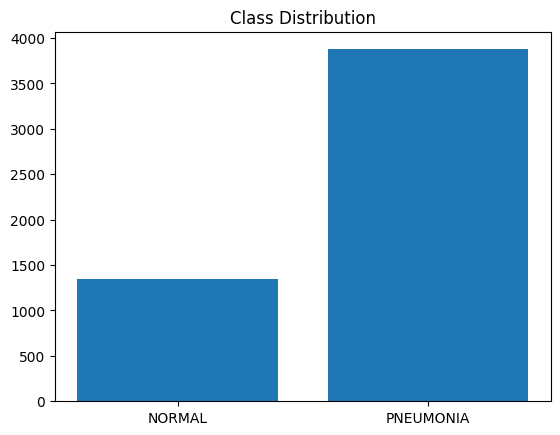

In [ ]:
normal_count = len(os.listdir(os.path.join(train_dir, "NORMAL")))
pneumonia_count = len(os.listdir(os.path.join(train_dir, "PNEUMONIA")))

print("NORMAL Images:", normal_count)
print("PNEUMONIA Images:", pneumonia_count)

plt.bar(["NORMAL", "PNEUMONIA"], [normal_count, pneumonia_count])
plt.title("Class Distribution")
plt.show()


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.10,
    rotation_range=25,
    zoom_range=0.3,
    shear_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    subset="training",
    target_size=(224,224),
    batch_size=32,
    class_mode='binary'
)

val_gen = train_datagen.flow_from_directory(
    train_dir,
    subset="validation",
    target_size=(224,224),
    batch_size=32,
    class_mode='binary'
)


Found 4695 images belonging to 2 classes.
Found 521 images belonging to 2 classes.


In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 619 images belonging to 2 classes.


In [ ]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights="imagenet"
)

base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 349s 2s/step - accuracy: 0.7927 - loss: 0.4218 - val_accuracy: 0.8906 - val_loss: 0.2508
Epoch 2/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 356s 2s/step - accuracy: 0.9072 - loss: 0.2277 - val_accuracy: 0.9002 - val_loss: 0.2010
Epoch 3/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 303s 2s/step - accuracy: 0.9198 - loss: 0.1993 - val_accuracy: 0.9232 - val_loss: 0.2004
Epoch 4/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 304s 2s/step - accuracy: 0.9237 - loss: 0.1799 - val_accuracy: 0.9251 - val_loss: 0.2012
Epoch 5/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 304s 2s/step - accuracy: 0.9264 - loss: 0.1712 - val_accuracy: 0.9328 - val_loss: 0.1856
Epoch 6/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 298s 2s/step - accuracy: 0.9255 - loss: 0.1698 - val_accuracy: 0.9213 - val_loss: 0.1845
Epoch 7/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 314s 2s/step - accuracy: 0.9309 - loss: 0.1781 - val_accuracy: 0.9175 - val_loss: 0.1838
Epoch 8/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 319s 2s/step - accuracy: 0.9267 - loss: 0.1677 - val_accu

In [ ]:
base_model.trainable = True

for layer in base_model.layers[:-50]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

class_weight = {0: 1.5, 1: 1.0}

lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=1e-7
)

history_fine = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    class_weight=class_weight,
    callbacks=[lr_callback]
)


Epoch 1/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 469s 3s/step - accuracy: 0.8357 - loss: 0.4390 - val_accuracy: 0.9155 - val_loss: 0.2001 - learning_rate: 1.0000e-05
Epoch 2/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 456s 3s/step - accuracy: 0.9034 - loss: 0.2837 - val_accuracy: 0.8714 - val_loss: 0.2942 - learning_rate: 1.0000e-05
Epoch 3/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 420s 3s/step - accuracy: 0.9247 - loss: 0.2330 - val_accuracy: 0.8695 - val_loss: 0.3746 - learning_rate: 1.0000e-05
Epoch 4/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 428s 3s/step - accuracy: 0.9303 - loss: 0.2016 - val_accuracy: 0.8618 - val_loss: 0.3581 - learning_rate: 2.0000e-06
Epoch 5/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 416s 3s/step - accuracy: 0.9293 - loss: 0.1949 - val_accuracy: 0.8791 - val_loss: 0.3049 - learning_rate: 2.0000e-06
Epoch 6/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 415s 3s/step - accuracy: 0.9296 - loss: 0.2161 - val_accuracy: 0.8964 - val_loss: 0.2895 - learning_rate: 4.0000e-07
Epoch 7/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 414s 3s/step - acc

In [ ]:

test_loss, test_acc = model.evaluate(test_gen)
print("✅ FINAL TEST ACCURACY:", round(test_acc * 100, 2), "%")


20/20 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.8921 - loss: 0.2879
✅ FINAL TEST ACCURACY: 87.4 %


20/20 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step


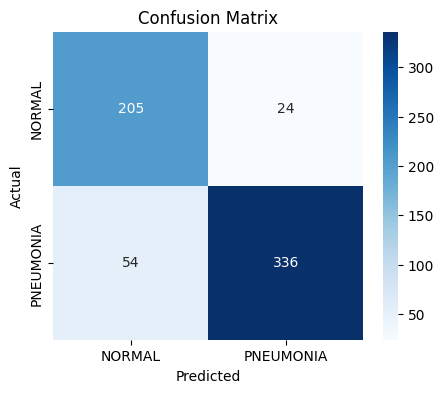

Classification Report:

              precision    recall  f1-score   support

      NORMAL       0.79      0.90      0.84       229
   PNEUMONIA       0.93      0.86      0.90       390

    accuracy                           0.87       619
   macro avg       0.86      0.88      0.87       619
weighted avg       0.88      0.87      0.88       619



In [ ]:
pred_probs = model.predict(test_gen)
pred_labels = (pred_probs > 0.5).astype(int)

true_labels = test_gen.classes

cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["NORMAL", "PNEUMONIA"],
            yticklabels=["NORMAL", "PNEUMONIA"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n")
print(classification_report(true_labels, pred_labels, target_names=["NORMAL", "PNEUMONIA"]))


In [ ]:
model.save("/content/drive/MyDrive/pneumonia_final.keras")
print("✅ MODEL SAVED SUCCESSFULLY")


✅ MODEL SAVED SUCCESSFULLY


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


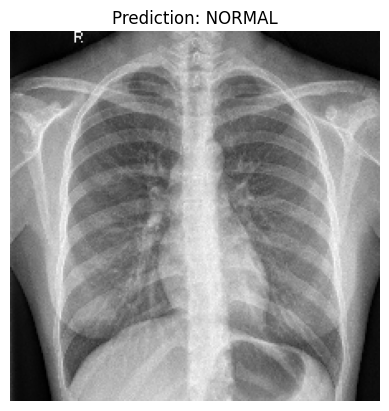

In [ ]:
IMG_SIZE = 224

img_path = test_gen.filepaths[5]

img = tf.keras.utils.load_img(img_path, target_size=(224,224))
img_array = tf.keras.utils.img_to_array(img)/255.0
img_array = np.expand_dims(img_array, axis=0)

prob = model.predict(img_array)[0][0]
label = "PNEUMONIA" if prob > 0.5 else "NORMAL"

plt.imshow(img)
plt.title(f"Prediction: {label}")
plt.axis("off")
plt.show()
